# Imports

In [ ]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

In [ ]:
from uom_project import poisson_solvers
import numpy as np
import matplotlib.pyplot as plt

# Speed comparison

10
14
20
28


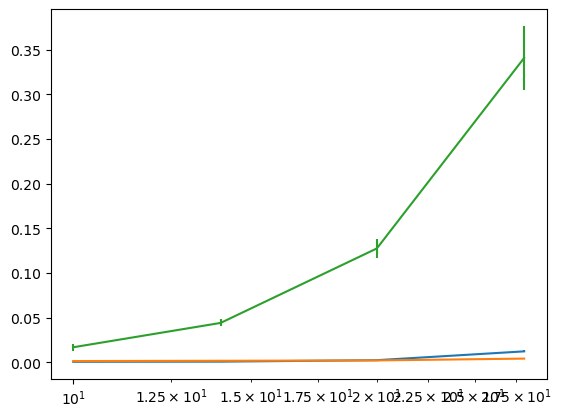

In [ ]:
time_simple = []
errors_simple = []

time_sparse = []
errors_sparse = []

time_gs = []
errors_gs = []

N_values = np.array([10, 14, 20, 28])

for N in N_values:
    print(N)
    
    nx = ny = N + 1
    h = 1 / N
    x_grid, y_grid = np.meshgrid(
        np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
    )
    x_grid = x_grid.astype(np.float32)
    y_grid = y_grid.astype(np.float32)
    w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
    w = w.astype(np.float32)
    
    # simple
    time = %timeit -o -q poisson_solvers.poisson_non_iterative_solver(w, use_sparse=False)
    time_simple.append(time.average)
    errors_simple.append(time.stdev)
    
    # sparse
    time = %timeit -o -q poisson_solvers.poisson_non_iterative_solver(w, use_sparse=True)
    time_sparse.append(time.average)
    errors_sparse.append(time.stdev)
    
    # gs
    time = %timeit -o -q poisson_solvers.poisson_gauss_seidel_with_sor_solver(w, verbose=False)
    time_gs.append(time.average)
    errors_gs.append(time.stdev)


In [ ]:
import pandas as pd

def df_from_performance_metrics(N_values, times, errors):
    return pd.DataFrame({
        "N": N_values,
        "time": times,
        "std": errors,
    })

df = df_from_performance_metrics(N_values, time_sparse, errors_sparse)
df.to_csv("../logs/time-sparse.csv", index=False)

df = df_from_performance_metrics(N_values, time_simple, errors_simple)
df.to_csv("../logs/time-dense.csv", index=False)

df = df_from_performance_metrics(N_values, time_gs, errors_gs)
df.to_csv("../logs/time-gs.csv", index=False)

ValueError: All arrays must be of the same length

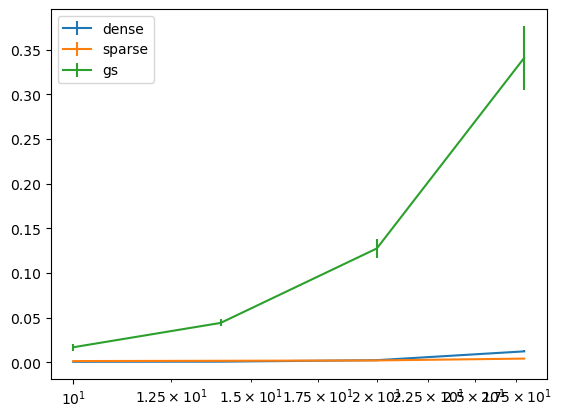

In [ ]:
for solver in ["dense", "sparse", "gs"]:
    df = pd.read_csv(f"../logs/time-{solver}.csv")
    plt.errorbar(x=df["N"], y=df["time"], yerr=df["std"], label=solver)
    
plt.legend()
plt.xscale("log")

sparse
7
14
28

newton
7
14
28

newton-alternative
7
14
28



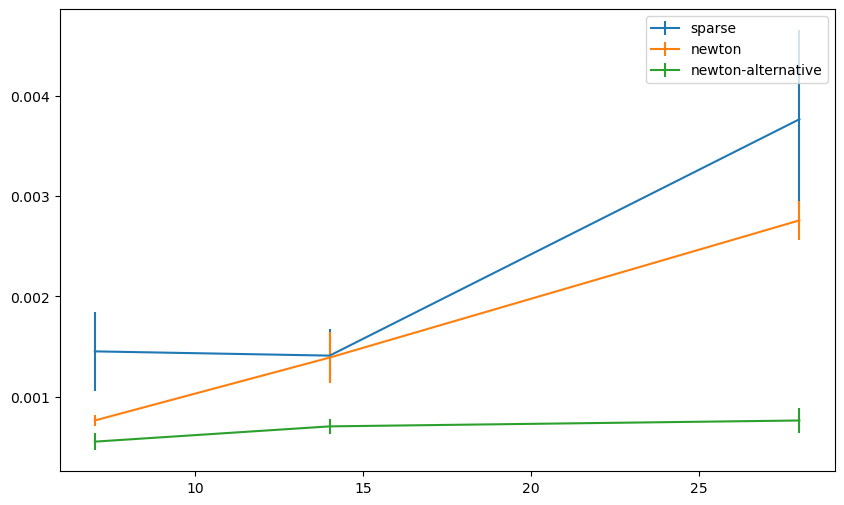

CPU times: user 40.8 s, sys: 906 ms, total: 41.7 s
Wall time: 48.8 s


In [ ]:
%%time

# N_values = np.array([7, 14, 28, 56, 84, 112, 224, 336, 448])
N_values = np.array([7, 14, 28])

plt.figure(figsize=(10, 6))

options = { "line_search": None, "jac_options": { "reduction_method": "svd" } }
alternative_kwargs = { "method": "broyden2", "options": options }

for method_name, method, kwargs in [
    ("sparse", poisson_solvers.poisson_non_iterative_solver, None),
    ("newton", poisson_solvers.newton_solver, None),
    ("newton-alternative", poisson_solvers.newton_alternative, alternative_kwargs)
]:
    print(method_name)
    times = []
    errors = []
    
    for N in N_values:
        print(N)

        nx = ny = N + 1
        x_grid, y_grid = np.meshgrid(
            np.linspace(0, 1, nx), np.linspace(0, 1, ny), indexing="ij"
        )
        w = 2 * np.pi ** 2 * np.sin(np.pi * x_grid) * np.sin(np.pi * y_grid) # vorticity
        
        if kwargs is None:
            time = %timeit -o -q method(w)
        else:
            time = %timeit -o -q method(w, **kwargs)
        times.append(time.average)
        errors.append(time.stdev)

    plt.errorbar(x=N_values, y=times, yerr=errors, label=method_name)
    print()

plt.legend()
plt.show()